In [55]:
%matplotlib inline
%timeit

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import time
import pickle
import datetime
import re
import pyActigraphy

import sys
sys.path.append('/home/ngrav/project/')
from wearables.scripts import utils as wearutils
from wearables.scripts import data as weardata
from wearables.scripts import train as weartrain
from wearables.scripts import eval_ as weareval
from wearables.scripts import model as wearmodels
from wearables.scripts import DTW as weardtw

import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.spatial.distance import pdist, squareform
import fastdtw
import umap

from scipy.stats import mannwhitneyu, spearmanr

plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=1
plt.rcParams['savefig.dpi'] = 600
sns.set_style("ticks")

In [27]:
pfp = '/home/ngrav/project/wearables/results/'
fname = 'featattr_res_220310.pkl'

def loadpkl(full_fname):
    with open(full_fname, 'rb') as f:
        return pickle.load(f)
    
def p_encoder(p):
    if p > 0.05:
        label = '' # n.s.
    elif p <= 0.001:
        label = '***'
    elif p <= 0.05 and p > 0.01:
        label = '*'
    elif p <= 0.01 and p > 0.001:
        label = '**'
    else: 
        label = 'Unclassified'
    return label

In [5]:
# load data
res = loadpkl(os.path.join(pfp, fname))

In [6]:
res.keys()

dict_keys(['res_4wk', 'res_err_grps', 'res_errgrp_ptb', 'imp_errgrp_mdvar_corrs', 'errcorr', 'errcorr_morningVevening', 'errcorr_weekdayVweekend', 'errcorr_dayVnight', 'errcorr_sleep', 'errcorr_group', 'impcorr_morningVevening', 'impcorr_weekdayVweekend', 'impcorr_dayVnight', 'impcorr_sleep', 'impcorr_group'])

In [30]:
df = res['res_4wk']
n_samples = 1000
df.head()

,attr,uid,sleep,t,morningVevening,weekdayVweekend,dayVnight,group,abs_attr
0,0.0,1720_16,1,2019-02-28 00:00:00,NA,Weekday,Night,lt4wk,0.0
1,0.0,1720_16,1,2019-02-28 00:01:00,NA,Weekday,Night,lt4wk,0.0
2,0.0,1720_16,1,2019-02-28 00:02:00,NA,Weekday,Night,lt4wk,0.0
3,0.0,1720_16,1,2019-02-28 00:03:00,NA,Weekday,Night,lt4wk,0.0
4,0.0,1720_16,1,2019-02-28 00:04:00,NA,Weekday,Night,lt4wk,0.0


In [31]:

a = df.loc[(df['morningVevening']=='Morning') & (df['sleep']==0), 'abs_attr']
b = df.loc[(df['morningVevening']=='Evening') & (df['sleep']==0), 'abs_attr']
stat, p = mannwhitneyu(a if n_samples is None else np.random.choice(a, n_samples), 
                       b if n_samples is None else np.random.choice(b, n_samples))
print(f"a:{a.shape}\tb:{b.shape}\t<b>-<a>: {np.mean(b) - np.mean(a):.2f}\tp:{p:.2e}{p_encoder(p)}")


a:(216529,)	b:(194918,)	<b>-<a>: 0.01	p:4.48e-03**


In [35]:

a = df.loc[(df['morningVevening']=='Morning') & (df['sleep']==1), 'abs_attr']
b = df.loc[(df['morningVevening']=='Evening') & (df['sleep']==1), 'abs_attr']
stat, p = mannwhitneyu(a if n_samples is None else np.random.choice(a, n_samples), 
                       b if n_samples is None else np.random.choice(b, n_samples))
print(f"a:{a.shape}\tb:{b.shape}\t<b>-<a>: {np.mean(b) - np.mean(a):.2f}\tp:{p:.2e}{p_encoder(p)}")


a:(287471,)	b:(309082,)	<b>-<a>: 0.00	p:3.09e-01


In [36]:

a = df.loc[(df['weekdayVweekend']=='Weekday') & (df['sleep']==0), 'abs_attr']
b = df.loc[(df['weekdayVweekend']=='Weekend') & (df['sleep']==0), 'abs_attr']
stat, p = mannwhitneyu(a if n_samples is None else np.random.choice(a, n_samples), 
                       b if n_samples is None else np.random.choice(b, n_samples))
print(f"a:{a.shape}\tb:{b.shape}\t<b>-<a>: {np.mean(b) - np.mean(a):.2f}\tp:{p:.2e}{p_encoder(p)}")


a:(530008,)	b:(194222,)	<b>-<a>: 0.00	p:4.09e-01


In [37]:

a = df.loc[(df['weekdayVweekend']=='Weekday') & (df['sleep']==1), 'abs_attr']
b = df.loc[(df['weekdayVweekend']=='Weekend') & (df['sleep']==1), 'abs_attr']
stat, p = mannwhitneyu(a if n_samples is None else np.random.choice(a, n_samples), 
                       b if n_samples is None else np.random.choice(b, n_samples))
print(f"a:{a.shape}\tb:{b.shape}\t<b>-<a>: {np.mean(b) - np.mean(a):.2f}\tp:{p:.2e}{p_encoder(p)}")


a:(909992,)	b:(381778,)	<b>-<a>: -0.00	p:1.48e-01


In [38]:

a = df.loc[(df['dayVnight']=='Day') & (df['sleep']==0), 'abs_attr']
b = df.loc[(df['dayVnight']=='Night') & (df['sleep']==0), 'abs_attr']
stat, p = mannwhitneyu(a if n_samples is None else np.random.choice(a, n_samples), 
                       b if n_samples is None else np.random.choice(b, n_samples))
print(f"a:{a.shape}\tb:{b.shape}\t<b>-<a>: {np.mean(b) - np.mean(a):.2f}\tp:{p:.2e}{p_encoder(p)}")


a:(483652,)	b:(240578,)	<b>-<a>: 0.01	p:1.15e-03**


In [39]:

a = df.loc[(df['dayVnight']=='Day') & (df['sleep']==1), 'abs_attr']
b = df.loc[(df['dayVnight']=='Night') & (df['sleep']==1), 'abs_attr']
stat, p = mannwhitneyu(a if n_samples is None else np.random.choice(a, n_samples), 
                       b if n_samples is None else np.random.choice(b, n_samples))
print(f"a:{a.shape}\tb:{b.shape}\t<b>-<a>: {np.mean(b) - np.mean(a):.2f}\tp:{p:.2e}{p_encoder(p)}")


a:(524348,)	b:(767422,)	<b>-<a>: 0.00	p:9.08e-07***


In [40]:

a = df.loc[(df['sleep']==0), 'abs_attr']
b = df.loc[(df['sleep']==1), 'abs_attr']
stat, p = mannwhitneyu(a if n_samples is None else np.random.choice(a, n_samples), 
                       b if n_samples is None else np.random.choice(b, n_samples))
print(f"a:{a.shape}\tb:{b.shape}\t<b>-<a>: {np.mean(b) - np.mean(a):.2f}\tp:{p:.2e}{p_encoder(p)}")


a:(724230,)	b:(1291770,)	<b>-<a>: -0.02	p:5.18e-266***


### IS/RA vs. imp/err

In [41]:
df = res['res_err_grps']
df.head()

,attr,uid,sleep,t,morningVevening,weekdayVweekend,dayVnight,group,abs_attr
0,0.0,2283_23,1,2018-08-21 00:00:00,NA,Weekday,Night,lt10wks,0.0
1,0.0,2283_23,1,2018-08-21 00:01:00,NA,Weekday,Night,lt10wks,0.0
2,0.0,2283_23,1,2018-08-21 00:02:00,NA,Weekday,Night,lt10wks,0.0
3,0.0,2283_23,1,2018-08-21 00:03:00,NA,Weekday,Night,lt10wks,0.0
4,0.0,2283_23,1,2018-08-21 00:04:00,NA,Weekday,Night,lt10wks,0.0


In [46]:
# load md info
from wearables.scripts.md_specification import mdpred_voi_v2

# filepaths to bst or pre-processed md with calculated metrics 
pp_md_fp = os.path.join(pfp, 'md_v522_220124.csv')

# load up to date md
md = pd.read_csv(pp_md_fp, index_col=0)


In [47]:
md.head()

,record_id,age_enroll,marital,gestage_by,insur,ethnicity,race,bmi_1vis,prior_ptb_all,fullterm_births,...,visit_num,PQSI,KPAS,EpworthSS,Edinburgh,Pre-term birth,y,yhat,split,error
unique_id,,,,,,,,,,,,,,,,,,,,,
1024_10,1024,23.0,0.0,0.0,5.0,0.0,1.0,21.378954,0.0,1.0,...,1,4.0,4.571429,0.0,0.0,False,10.0,15.463044,train,5.463044
2180_12,2180,34.0,1.0,1.0,3.0,0.0,0.0,31.732640,0.0,0.0,...,1,10.0,9.053680,5.0,6.0,False,12.0,11.777130,train,-0.222870
2148_11,2148,34.0,1.0,2.0,3.0,0.0,0.0,22.406605,0.0,1.0,...,1,11.0,10.266234,9.0,7.0,False,11.0,18.814798,train,7.814798
1062_8,1062,31.0,0.0,1.0,5.0,0.0,1.0,40.106270,0.0,0.0,...,1,8.0,9.493074,3.0,5.0,False,8.0,14.428290,train,6.428290
1306_7,1306,25.0,0.0,3.0,5.0,0.0,1.0,24.555670,0.0,0.0,...,1,10.0,8.889610,9.0,9.0,False,7.0,16.641426,train,9.641426


In [48]:
md_coi = [i for i in list(mdpred_voi_v2.keys()) if i in md.columns]
dt = df.merge(md.loc[:, md_coi], left_on='uid', right_index=True, how='left')

# sample? takes too long otherwise
if True:
    dt = dt.sample(200000).reset_index()

In [49]:
dt.head()

,index,attr,uid,sleep,t,morningVevening,weekdayVweekend,dayVnight,group,abs_attr,...,ave_logpseudocount_wkday,ave_logpseudocount_day,ave_logpseudocount_night,PQSI,KPAS,EpworthSS,Edinburgh,GA,yhat,error
0,3004,0.000000,2107_8,1,2017-09-03 02:04:00,NA,Weekend,Night,lt10wks,0.000000,...,1.607853,1.020173,1.276759,8.0,10.382251,10.0,0.0,8.0,12.621911,4.621911
1,5021,-0.021170,2129_33,0,2018-02-17 11:41:00,Morning,Weekend,Day,Lower-than-actual,0.021170,...,2.563490,3.358504,1.889512,7.0,9.140043,6.0,0.0,33.0,20.547432,-12.452568
2,7262,0.000000,1062_13,1,2017-06-26 01:02:00,NA,Weekday,Night,Higher-than-actual,0.000000,...,3.144995,4.226732,1.163481,9.0,9.286147,5.0,1.0,13.0,24.246517,11.246517
3,9257,-0.006455,1367_14,1,2018-03-12 10:17:00,Morning,Weekday,Day,lt10wks,0.006455,...,1.853160,2.596935,1.067898,11.0,8.553030,4.0,3.0,14.0,19.031704,5.031704
4,9342,0.012059,1475_7,0,2018-06-08 11:42:00,Morning,Weekday,Day,Higher-than-actual,0.012059,...,2.427650,3.739000,0.999059,9.0,8.007576,9.0,3.0,7.0,18.753561,11.753561


In [52]:
savefigs = False
sleep_cmap = {0:'#FAD02C', 1:'#333652'}


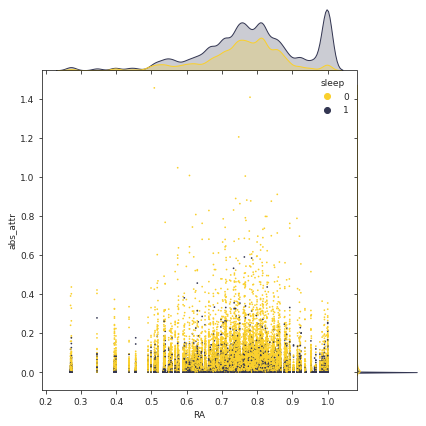

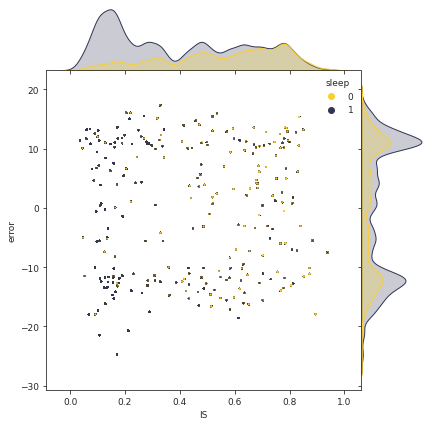

In [54]:
p1 = sns.jointplot(x='RA', y='abs_attr', data=dt, rasterized=True, hue='sleep', palette=sleep_cmap, linewidth=0, s=3, space=0)
if savefigs:
    p1.savefig(os.path.join(pfp, 'joinplot_impVRA_byslp.pdf'), bbox_inches='tight', dpi=600)

p2 = sns.jointplot(x='IS', y='error', data=dt, hue='sleep', rasterized=True, linewidth=0, palette=sleep_cmap, s=3, space=0)
if savefigs:
    p2.savefig(os.path.join(pfp, 'joinplot_errorVRA_byslp.pdf'), bbox_inches='tight', dpi=600)

In [56]:
n_samples = None

In [57]:
dt.head()

,index,attr,uid,sleep,t,morningVevening,weekdayVweekend,dayVnight,group,abs_attr,...,ave_logpseudocount_wkday,ave_logpseudocount_day,ave_logpseudocount_night,PQSI,KPAS,EpworthSS,Edinburgh,GA,yhat,error
0,3004,0.000000,2107_8,1,2017-09-03 02:04:00,NA,Weekend,Night,lt10wks,0.000000,...,1.607853,1.020173,1.276759,8.0,10.382251,10.0,0.0,8.0,12.621911,4.621911
1,5021,-0.021170,2129_33,0,2018-02-17 11:41:00,Morning,Weekend,Day,Lower-than-actual,0.021170,...,2.563490,3.358504,1.889512,7.0,9.140043,6.0,0.0,33.0,20.547432,-12.452568
2,7262,0.000000,1062_13,1,2017-06-26 01:02:00,NA,Weekday,Night,Higher-than-actual,0.000000,...,3.144995,4.226732,1.163481,9.0,9.286147,5.0,1.0,13.0,24.246517,11.246517
3,9257,-0.006455,1367_14,1,2018-03-12 10:17:00,Morning,Weekday,Day,lt10wks,0.006455,...,1.853160,2.596935,1.067898,11.0,8.553030,4.0,3.0,14.0,19.031704,5.031704
4,9342,0.012059,1475_7,0,2018-06-08 11:42:00,Morning,Weekday,Day,Higher-than-actual,0.012059,...,2.427650,3.739000,0.999059,9.0,8.007576,9.0,3.0,7.0,18.753561,11.753561


In [71]:
# all, g1, g2
a_all = dt.loc[:, 'abs_attr']
b_all = dt.loc[:, 'RA']

a_slp = dt.loc[(dt['sleep']==1), 'abs_attr']
b_slp = dt.loc[(dt['sleep']==1), 'RA']

a_wk = dt.loc[(dt['sleep']==0), 'abs_attr']
b_wk = dt.loc[(dt['sleep']==0), 'RA']

def rho(a, b, n_samples=None, verbose=True):
    rho, p = spearmanr(a if n_samples is None else np.random.choice(a, n_samples), 
                       b if n_samples is None else np.random.choice(b, n_samples))
    if verbose:
        print(f"rho:{rho:.2f} (P={p:.2e}{p_encoder(p)})\t<b>-<a>: {np.mean(b) - np.mean(a):.2f}")
    return rho, p

    

rho_all, p_all = rho(a_all, b_all)
rho_slp, p_slp = rho(a_slp, b_slp)
rho_wk, p_wk = rho(a_wk, b_wk)

rho:-0.14 (P=0.00e+00***)	<b>-<a>: 0.76
rho:-0.12 (P=0.00e+00***)	<b>-<a>: 0.78
rho:-0.04 (P=9.08e-30***)	<b>-<a>: 0.73


In [72]:
# all, g1, g2
a_all = dt.loc[:, 'error']
b_all = dt.loc[:, 'IS']

a_slp = dt.loc[(dt['sleep']==1), 'error']
b_slp = dt.loc[(dt['sleep']==1), 'IS']

a_wk = dt.loc[(dt['sleep']==0), 'error']
b_wk = dt.loc[(dt['sleep']==0), 'IS']    

rho_all, p_all = rho(a_all, b_all)
rho_slp, p_slp = rho(a_slp, b_slp)
rho_wk, p_wk = rho(a_wk, b_wk)

rho:0.04 (P=1.61e-82***)	<b>-<a>: 0.59
rho:0.06 (P=1.59e-93***)	<b>-<a>: 0.74
rho:0.00 (P=2.87e-01)	<b>-<a>: 0.29


### bar plots summary

In [73]:
from wearables.scripts.aesthetics import md_node_annotation, md_node_category_cmap


In [103]:
k_a = 'errcorr_group'
dt = res[k_a]
dt['cat'] = dt.index.map(md_node_annotation)
dt = dt.loc[~dt['cat'].isna()]
dt = dt.reset_index().melt(id_vars=['cat', 'index'])
dt['value'] = dt['value'].abs()

for v in dt['variable'].unique():
    print(f"\ngrp: {v}")
    dtt = dt.loc[dt['variable']==v, :].sort_values(by='value', ascending=False)
    dtt = dtt.reset_index()
    print('  means per cat')
    print(dtt.groupby('cat').mean(0)['value'].to_dict())
    # print(dtt.groupby('cat').mean())
    print('\n  ranking:')
    for i in range(10):
        print(f"{i+1}\t{dtt.loc[i, 'index']} ({dtt.loc[i, 'cat']}): {dtt.loc[i, 'value']:.2f}")
    print('')


grp: all
  means per cat
{'Activity-related': 0.07816825909992413, 'Comorbidities': 0.5727471373279306, 'Depression-related': 0.58986049780345, 'Pregnancy outcome': 0.4587271359685465, 'Procedural': 0.22084487104563552, 'Sleep-quality': 0.6407590242035992, 'Social determinants of health': 0.593243052656228, 'Stress-related': 0.7742441321083052}

  ranking:
1	insur (Social determinants of health): 0.96
2	hypertension (Comorbidities): 0.81
3	deliv_mode (Procedural): 0.80
4	pregestational_diabetes (Comorbidities): 0.79
5	passenger1 (Sleep-quality): 0.78
6	edinb2_1trim (Depression-related): 0.78
7	stress2_1 (Stress-related): 0.77
8	stress9_1 (Stress-related): 0.77
9	stress7_1 (Stress-related): 0.77
10	stress8_1 (Stress-related): 0.77


grp: Higher-than-actual
  means per cat
{'Activity-related': 0.09264863181218017, 'Comorbidities': 0.5829786374997455, 'Depression-related': 0.6349351442675898, 'Pregnancy outcome': 0.4799001864927246, 'Procedural': 0.23807154139693615, 'Sleep-quality': 0.5

In [104]:
k_a = 'impcorr_group'
dt = res[k_a]
dt['cat'] = dt.index.map(md_node_annotation)
dt = dt.loc[~dt['cat'].isna()]
dt = dt.reset_index().melt(id_vars=['cat', 'index'])
dt['value'] = dt['value'].abs()

for v in dt['variable'].unique():
    print(f"\ngrp: {v}")
    dtt = dt.loc[dt['variable']==v, :].sort_values(by='value', ascending=False)
    dtt = dtt.reset_index()
    print('  means per cat')
    print(dtt.groupby('cat').mean(0)['value'].to_dict())
    # print(dtt.groupby('cat').mean())
    print('\n  ranking:')
    for i in range(10):
        print(f"{i+1}\t{dtt.loc[i, 'index']} ({dtt.loc[i, 'cat']}): {dtt.loc[i, 'value']:.2f}")
    print('')


grp: all
  means per cat
{'Activity-related': 0.21817530177803363, 'Comorbidities': 0.5094593222201336, 'Depression-related': 0.5327033177829977, 'Pregnancy outcome': 0.4090555327557912, 'Procedural': 0.1710126280092393, 'Sleep-quality': 0.5359662815228866, 'Social determinants of health': 0.5245957590746, 'Stress-related': 0.6005482164770909}

  ranking:
1	edinb10_1trim (Depression-related): 0.68
2	talking1 (Sleep-quality): 0.64
3	choosesleep_1trim (Sleep-quality): 0.62
4	workreg_1trim (Sleep-quality): 0.62
5	sitting1 (Sleep-quality): 0.61
6	cartraffic1 (Sleep-quality): 0.61
7	afterlunch1 (Sleep-quality): 0.61
8	passenger1 (Sleep-quality): 0.61
9	tv1 (Sleep-quality): 0.61
10	reset1 (Sleep-quality): 0.61


grp: Lower-than-actual
  means per cat
{'Activity-related': 0.29862051935684386, 'Comorbidities': 0.5242350427896046, 'Depression-related': 0.5261013564974003, 'Pregnancy outcome': 0.4301908371974717, 'Procedural': 0.19279351000541534, 'Sleep-quality': 0.5870156151803818, 'Social de

### ptb+/- AND slp/wk vs imp/err

In [118]:
df = res['res_4wk']
md_coi = [i for i in list(mdpred_voi_v2.keys()) if i in md.columns]
dt = df.merge(md.loc[:, md_coi], left_on='uid', right_index=True, how='left')

# sample? takes too long otherwise
if True:
    dt = dt.sample(200000).reset_index()
    
df = dt

In [120]:
n_samples = 1000

In [121]:

a = df.loc[(df['ptb_37wks']==0) & (df['sleep']==0), 'abs_attr']
b = df.loc[(df['ptb_37wks']==1) & (df['sleep']==0), 'abs_attr']
stat, p = mannwhitneyu(a if n_samples is None else np.random.choice(a, n_samples), 
                       b if n_samples is None else np.random.choice(b, n_samples))
print(f"a:{a.shape}\tb:{b.shape}\t<b>-<a>: {np.mean(b) - np.mean(a):.2f}\tp:{p:.2e}{p_encoder(p)}")


a:(60425,)	b:(11132,)	<b>-<a>: 0.00	p:3.54e-01


In [122]:

a = df.loc[(df['ptb_37wks']==0) & (df['sleep']==1), 'abs_attr']
b = df.loc[(df['ptb_37wks']==1) & (df['sleep']==1), 'abs_attr']
stat, p = mannwhitneyu(a if n_samples is None else np.random.choice(a, n_samples), 
                       b if n_samples is None else np.random.choice(b, n_samples))
print(f"a:{a.shape}\tb:{b.shape}\t<b>-<a>: {np.mean(b) - np.mean(a):.2f}\tp:{p:.2e}{p_encoder(p)}")


a:(107764,)	b:(20679,)	<b>-<a>: 0.00	p:6.23e-02


In [123]:

a = df.loc[(df['ptb_37wks']==0) & (df['sleep']==0), 'abs_attr']
b = df.loc[(df['ptb_37wks']==0) & (df['sleep']==1), 'abs_attr']
stat, p = mannwhitneyu(a if n_samples is None else np.random.choice(a, n_samples), 
                       b if n_samples is None else np.random.choice(b, n_samples))
print(f"a:{a.shape}\tb:{b.shape}\t<b>-<a>: {np.mean(b) - np.mean(a):.2f}\tp:{p:.2e}{p_encoder(p)}")


a:(60425,)	b:(107764,)	<b>-<a>: -0.02	p:5.75e-260***


In [124]:

a = df.loc[(df['ptb_37wks']==1) & (df['sleep']==0), 'abs_attr']
b = df.loc[(df['ptb_37wks']==1) & (df['sleep']==1), 'abs_attr']
stat, p = mannwhitneyu(a if n_samples is None else np.random.choice(a, n_samples), 
                       b if n_samples is None else np.random.choice(b, n_samples))
print(f"a:{a.shape}\tb:{b.shape}\t<b>-<a>: {np.mean(b) - np.mean(a):.2f}\tp:{p:.2e}{p_encoder(p)}")


a:(11132,)	b:(20679,)	<b>-<a>: -0.02	p:1.97e-277***


In [126]:

a = df.loc[(df['ptb_37wks']==0) & (df['sleep']==0), 'error']
b = df.loc[(df['ptb_37wks']==1) & (df['sleep']==0), 'error']
stat, p = mannwhitneyu(a if n_samples is None else np.random.choice(a, n_samples), 
                       b if n_samples is None else np.random.choice(b, n_samples))
print(f"a:{a.shape}\tb:{b.shape}\t<b>-<a>: {np.mean(b) - np.mean(a):.2f}\tp:{p:.2e}{p_encoder(p)}")


a:(60425,)	b:(11132,)	<b>-<a>: 1.73	p:1.43e-09***


In [125]:

a = df.loc[(df['ptb_37wks']==0) & (df['sleep']==1), 'error']
b = df.loc[(df['ptb_37wks']==1) & (df['sleep']==1), 'error']
stat, p = mannwhitneyu(a if n_samples is None else np.random.choice(a, n_samples), 
                       b if n_samples is None else np.random.choice(b, n_samples))
print(f"a:{a.shape}\tb:{b.shape}\t<b>-<a>: {np.mean(b) - np.mean(a):.2f}\tp:{p:.2e}{p_encoder(p)}")


a:(107764,)	b:(20679,)	<b>-<a>: 2.75	p:1.58e-13***


In [130]:

a = df.loc[(df['ptb_37wks']==0) & (df['sleep']==0), 'error']
b = df.loc[(df['ptb_37wks']==0) & (df['sleep']==1), 'error']
stat, p = mannwhitneyu(a if n_samples is None else np.random.choice(a, n_samples), 
                       b if n_samples is None else np.random.choice(b, n_samples))
print(f"a:{a.shape}\tb:{b.shape}\t<b>-<a>: {np.mean(b) - np.mean(a):.2f}\tp:{p:.2e}{p_encoder(p)}")


a:(60425,)	b:(107764,)	<b>-<a>: 0.01	p:4.51e-01


In [128]:

a = df.loc[(df['ptb_37wks']==1) & (df['sleep']==0), 'error']
b = df.loc[(df['ptb_37wks']==1) & (df['sleep']==1), 'error']
stat, p = mannwhitneyu(a if n_samples is None else np.random.choice(a, n_samples), 
                       b if n_samples is None else np.random.choice(b, n_samples))
print(f"a:{a.shape}\tb:{b.shape}\t<b>-<a>: {np.mean(b) - np.mean(a):.2f}\tp:{p:.2e}{p_encoder(p)}")


a:(11132,)	b:(20679,)	<b>-<a>: 1.03	p:1.94e-04***
